<a href="https://colab.research.google.com/github/santhoshgandham/Applied-Programming-Lab/blob/main/Eyantra.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import os
from pathlib import Path
import cv2
# Setup path to data folder
data_path = Path("drive/MyDrive")
image_path = data_path / "training"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
os.listdir('/content/drive/MyDrive/training')
training_dataset_path='/content/drive/MyDrive/training'

In [ ]:
import os
import numpy as np
import torchvision
import torch
import torchvision.transforms as transforms

In [ ]:
import cv2
import numpy as np
from torchvision import transforms
from PIL import Image

# Define the CLAHE function
def apply_clahe(img):
    clahe = cv2.createCLAHE(clipLimit=2)
    img_np = np.array(img)

    # Assuming img_np is a 3-channel image (BGR)
    """b, g, r = cv2.split(img_np)
    b = clahe.apply(b)
    g = clahe.apply(g)
    r = clahe.apply(r)
    merged_bgr = cv2.merge((b, g, r))"""
    image_hsv = cv2.cvtColor ( img_np , cv2.COLOR_BGR2HSV )
    h , s , v = cv2.split ( image_hsv )
    v = clahe.apply ( v )
    merged_hsv = cv2.merge ( (h , s , v) )
    bgr_enhanced = cv2.cvtColor ( merged_hsv , cv2.COLOR_HSV2BGR )

    # Convert back to PIL Image
    img_pil = Image.fromarray(cv2.cvtColor(bgr_enhanced, cv2.COLOR_BGR2RGB))

    return img_pil

# Custom CLAHE transformation
class CLAHETransform(object):
    def __call__(self, img):
        return apply_clahe(img)

# Combine all transformations
training_transforms = transforms.Compose([
    transforms.Resize((86, 86)),
    CLAHETransform(),
    transforms.ToTensor(),
])

In [ ]:
train_dataset=torchvision.datasets.ImageFolder(root=training_dataset_path,transform=training_transforms)

In [ ]:
train_loader=torch.utils.data.DataLoader(dataset=train_dataset,batch_size=16,shuffle=False)

In [ ]:
def get_mean_and_std(loader):
  mean=0.
  std=0.
  total_images_count=0
  for images,_ in loader:
    image_count_in_a_batch=images.size(0);
    images=images.view(image_count_in_a_batch,images.size(1),-1)
    mean+=images.mean(2).sum(0)
    std+=images.std(2).sum(0)
    total_images_count+=image_count_in_a_batch
  mean/=total_images_count
  std/=total_images_count
  return mean,std

In [ ]:
get_mean_and_std(train_loader)

(tensor([0.4546, 0.4761, 0.5129]), tensor([0.2395, 0.2363, 0.2445]))

In [ ]:
train_dataset_path='/content/drive/MyDrive/training'

In [ ]:
test_dataset_path='/content/drive/MyDrive/testing1'

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
mean=[0.4546, 0.4761, 0.5129]
std=[0.2395, 0.2363, 0.2445]

In [ ]:
import random
import torch
from torchvision import transforms
from PIL import Image

# Define a small range for random brightness adjustment
brightness_factor = 0.02  # You can adjust this value based on your preference

# Custom lambda function to add slight noise to the image
add_noise = lambda x: transforms.ToTensor()(x) + torch.randn_like(transforms.ToTensor()(x)) * 0.002  # Adjust the noise level (0.05 in this case)

train_transforms = transforms.Compose([
    transforms.Resize((86, 86)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(
        contrast=(0.95,1.05)
    ),
    CLAHETransform(),
    transforms.RandomResizedCrop(size=(86, 86), scale=(0.9, 1.0), ratio=(1.0, 1.0)),
    # Add slight noise
    transforms.Lambda(lambda x: transforms.ToPILImage()(add_noise(x))),
    transforms.RandomAffine(degrees=10, translate=(0.1, 0.1),shear=(3, 3)),
    transforms.ToTensor(),
    transforms.Normalize(torch.Tensor(mean), torch.Tensor(std))

])

test_transforms = transforms.Compose([
    transforms.Resize((86, 86)),
    CLAHETransform(),
    transforms.ToTensor(),
    transforms.Normalize(torch.Tensor(mean), torch.Tensor(std))
])

In [ ]:
train_dataset=torchvision.datasets.ImageFolder(root=train_dataset_path,transform=train_transforms)
test_dataset=torchvision.datasets.ImageFolder(root=test_dataset_path,transform=test_transforms)

In [ ]:
def show_transformed_images(dataset):
  loader=torch.utils.data.DataLoader(dataset,batch_size=32,shuffle=True)
  batch=next(iter(loader))
  images,labels=batch
  grid=torchvision.utils.make_grid(images,nrow=3)
  plt.figure(figsize=(11,11))
  plt.imshow(np.transpose(grid,(1,2,0)))
  print("labels:",labels)

labels: tensor([4, 0, 2, 1, 3, 3, 3, 3, 3, 1, 1, 4, 3, 3, 0, 0, 3, 1, 1, 3, 2, 3, 1, 1,
        2, 4, 1, 1, 0, 2, 4, 1])


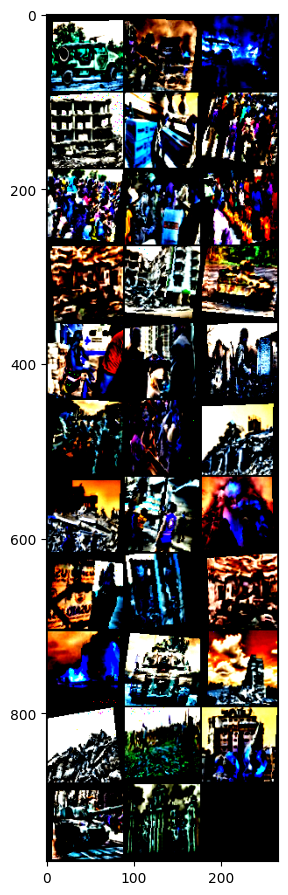

In [ ]:
show_transformed_images(train_dataset)

In [ ]:
train_loader=torch.utils.data.DataLoader(train_dataset,batch_size=32,shuffle=True)
test_loader=torch.utils.data.DataLoader(test_dataset,batch_size=32,shuffle=False)

In [ ]:
def set_device():
  if torch.cuda.is_available():
    dev="cuda:0"
  else:
    dev="cpu"
  return torch.device(dev)

In [ ]:
def train_nn(model, train_loader,test_loader,criterion,optimizer,n_epochs):
  device=set_device()
  best_acc=0
  best_epoch_loss=1000
  for epoch in range(n_epochs):
    print("Epoch number%d"%(epoch+1))
    model.train()
    running_loss=0.0
    running_correct=0.0
    total=0
    for data in train_loader:
      images,labels=data
      images=images.to(device)
      labels=labels.to(device)
      total+=labels.size(0)
      optimizer.zero_grad()
      outputs=model(images)
      _,predicted=torch.max(outputs.data,1)

      loss=criterion(outputs,labels)
      loss.backward()
      optimizer.step()
      running_loss+=loss.item()
      running_correct+=(labels==predicted).sum().item()

    epoch_loss=running_loss/len(train_loader)
    epoch_acc=100.00*running_correct/total
    print("    -Training dataset. Got %d out of %d images correctly (%.3f%%). Epoch loss: %.3f" % (running_correct, total, epoch_acc, epoch_loss))
    test_dataset_accuracy=evaluate_model_on_test_set(model,test_loader)
    if test_dataset_accuracy>=best_acc:
      if epoch_loss<best_epoch_loss:
        best_epoch_loss=epoch_loss
        best_acc=test_dataset_accuracy
        save_checkpoint(model,epoch,optimizer,best_acc,best_epoch_loss)


  print("Finished")
  return model

In [ ]:
def save_checkpoint(model,epoch,optimizer,best_acc,best_epoch_loss):
  state={"epoch":epoch+1,"model":model.state_dict(),"best accuracy":best_acc,"optimizer":optimizer.state_dict(),"epoch loss":best_epoch_loss}
  torch.save(state,"model_best_checkpoint.pth.tar")

In [ ]:
def evaluate_model_on_test_set(model,test_loader):
  model.eval()
  predicted_correctly_on_epoch=0
  total=0
  device=set_device()
  with torch.no_grad():
    for data in test_loader:
      images,labels=data
      images=images.to(device)
      labels=labels.to(device)
      total+=labels.size(0)
      outputs=model(images)
      _,predicted=torch.max(outputs.data,1)
      predicted_correctly_on_epoch+=(predicted==labels).sum().item()

  epoch_acc=100.00*predicted_correctly_on_epoch/total

  print("    -Testing dataset. Got %d out of %d images correctly (%.3f%%)" % (predicted_correctly_on_epoch, total, epoch_acc))
  return epoch_acc

In [ ]:
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim


resnet18_model=models.resnet34(pretrained=True)##resnet18_model = models.resnet18(weights="imagenet")
num_ftrs=resnet18_model.fc.in_features
number_of_classes=5
resnet18_model.fc=nn.Linear(num_ftrs,number_of_classes)
device=set_device()
resnet18_model=resnet18_model.to(device)
loss_fn=nn.CrossEntropyLoss()
optimizer=optim.SGD(resnet18_model.parameters(),lr=0.0076,momentum=0.7,weight_decay=0.002)
n_epochs=12

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 263MB/s]


In [ ]:
train_nn(resnet18_model, train_loader,test_loader,loss_fn,optimizer,n_epochs)

Epoch number1
    -Training dataset. Got 204 out of 432 images correctly (47.222%). Epoch loss: 1.263
    -Testing dataset. Got 7 out of 30 images correctly (23.333%)
Epoch number2
    -Training dataset. Got 349 out of 432 images correctly (80.787%). Epoch loss: 0.579
    -Testing dataset. Got 24 out of 30 images correctly (80.000%)
Epoch number3
    -Training dataset. Got 366 out of 432 images correctly (84.722%). Epoch loss: 0.408
    -Testing dataset. Got 28 out of 30 images correctly (93.333%)
Epoch number4
    -Training dataset. Got 392 out of 432 images correctly (90.741%). Epoch loss: 0.271
    -Testing dataset. Got 24 out of 30 images correctly (80.000%)
Epoch number5
    -Training dataset. Got 402 out of 432 images correctly (93.056%). Epoch loss: 0.204
    -Testing dataset. Got 21 out of 30 images correctly (70.000%)
Epoch number6
    -Training dataset. Got 408 out of 432 images correctly (94.444%). Epoch loss: 0.139
    -Testing dataset. Got 28 out of 30 images correctly (93

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
checkpoint=torch.load("model_best_checkpoint.pth.tar")

In [ ]:
print(checkpoint["epoch"])
print(checkpoint["epoch loss"])
print(checkpoint["best accuracy"])

9
0.06634471632008042
100.0


In [ ]:
resnet18_model=models.resnet34()##resnet18_model = models.resnet18(weights="imagenet")
num_ftrs=resnet18_model.fc.in_features
number_of_classes=5
resnet18_model.fc=nn.Linear(num_ftrs,number_of_classes)
resnet18_model.load_state_dict(checkpoint["model"])
torch.save(resnet18_model,"/content/drive/MyDrive/34best_model61.pth")